In [2]:
import os 
import sys
import numpy as np 
import math 
import matplotlib.pyplot as plt 


# LWR （局部加权线性回归）
对别之前的普通线形回归，原来的线形回归需要最小化以下损失函数:
$$ L(\theta) = \sum_{i} (y_{i} - \theta^{T}x_{i})^{2}$$
而局部加权线性回归算法需要最小化以下损失函数:
$$ L(\theta) = \sum_{i} w_{i} (y_{i} - \theta^{T}x_{i})^{2}$$
其中的参数 $w_{i}$ 是根据样本点 $x_{i}$ 与预测点 $x_{0}$ 的距离计算得到的权重，具体计算方法如下:
$$ w_{i} = exp(-\frac{(x_{i} - x_{0})^{2}}{2\sigma^{2}})$$
其中 $\sigma$ 是高斯核带宽，用于控制权重的衰减速度。上式也叫做高斯核函数。Gaussian kernel function

In [ ]:
import numpy as np
import gc

class LWR(object):
    def __init__(self, theta_initial, alpha, bandwidth=1.0):
        """ 
        theta: shape(feature_num, )
        X: shape(batch, feature_num)
        y: shape(batch, )
        bandwidth: 高斯核的带宽参数，控制权重的分布
        """
        super().__init__()
        self.alpha = alpha  # 学习率
        self.theta_0 = 0.0  # 偏置
        self.theta_initial = theta_initial  # 初始权重
        self.bandwidth = bandwidth  # 高斯核带宽参数

    def compute_weights(self, X, x0):
        """
        计算基于高斯核的加权矩阵
        X: 训练数据，shape(batch, feature_num)
        x0: 当前待预测的数据点，shape(feature_num,)
        """
        # 计算每个样本点与当前点的距离
        diff = X - x0
        dist_sq = np.sum(diff ** 2, axis=1)
        # 使用高斯核计算权重
        weights = np.exp(-dist_sq / (2 * self.bandwidth ** 2))
        return np.diag(weights)  # 返回对角矩阵，每个对角线元素是对应样本点的权重

    def h(self, X):
        """ 预测函数，返回线性模型的预测结果 """
        return np.dot(X, self.theta_initial) + self.theta_0  # shape(batch, )

    def J(self, pred, y, weights):
        """ 加权的损失函数 """
        loss = np.sum(weights * (y - pred) ** 2) / (2 * np.sum(weights))  # 加权损失
        return loss

    def lwr(self, X, y, pred, x0):
        """ 
        更新权重（使用加权回归） 
        X: 特征矩阵，shape(batch, feature_num)
        y: 实际值，shape(batch, )
        pred: 当前预测结果，shape(batch, )
        x0: 当前待预测的点
        """
        weights = self.compute_weights(X, x0)  # 计算加权矩阵
        for j in range(X.shape[1]):  # 对每个特征进行更新
            X_j = X[:, j]  # 取第j个特征
            gradient = np.sum(weights * (y - pred) * X_j) / np.sum(weights)
            self.theta_initial[j] += self.alpha * gradient # 更新第j个特征的参数 theta

        # 更新偏置项
        self.theta_0 += self.alpha * np.sum(weights * (y - pred)) / np.sum(weights)
        return self.theta_initial

    def fit(self, X, y, epochs, x0):
        """
        训练模型
        X: 特征矩阵，shape(batch, feature_num)
        y: 实际值，shape(batch, )
        epochs: 训练的轮数
        x0: 当前待预测的点（用于局部回归）
        """
        loss_best = np.inf
        history_losses = []
        for epoch in range(epochs):
            # Forward
            pred = self.h(X)
            # 计算加权损失
            weights = self.compute_weights(X, x0)
            loss = self.J(pred, y, weights)
            # 更新参数
            self.lwr(X, y, pred, x0)
            if loss < loss_best:
                loss_best = loss
            history_losses.append(loss)
            #print(f'Epoch {epoch + 1} | Train Loss: {loss}')
        
        gc.collect()
        return history_losses


In [30]:
# 生成模拟数据
np.random.seed(0)
X = np.sort(np.random.rand(10, 1), axis=0)  # 生成100个随机数据点
y = np.sin(0.5*np.pi * X).flatten()  # 目标值是sin函数

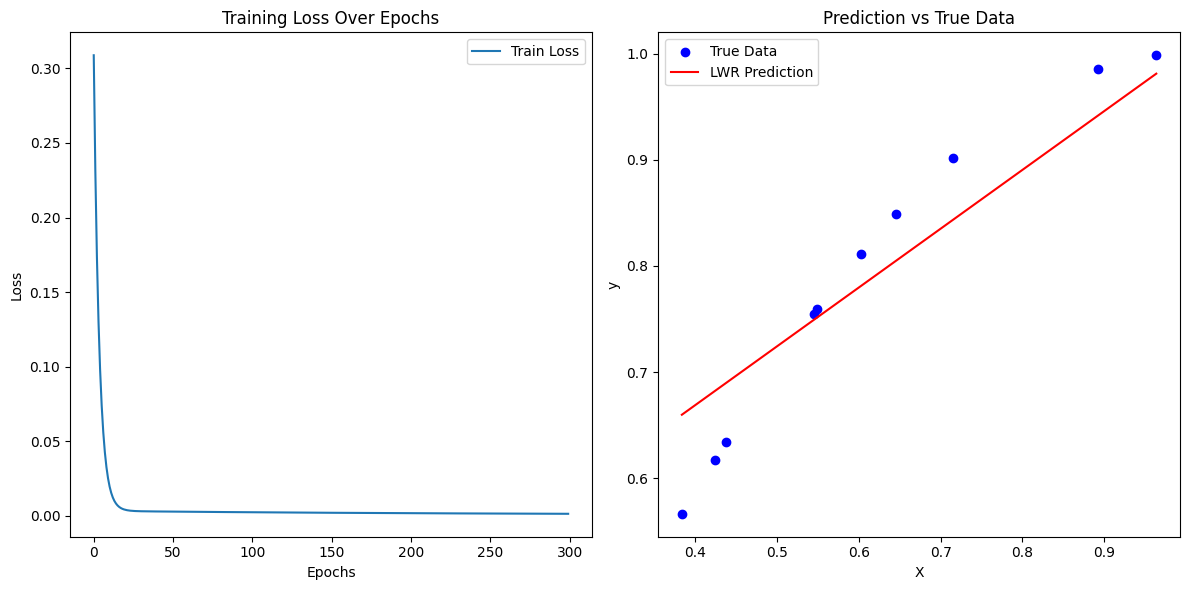

In [31]:
# 初始化LWR模型
theta_initial = np.zeros(X.shape[1])  # 初始权重
alpha = 0.1  # 学习率
bandwidth = 0.5 # 高斯核带宽
lwr_model = LWR(theta_initial, alpha, bandwidth)

# 设置训练参数
epochs = 300
x0 = 0.5 # 用于局部加权回归的预测点

# 训练模型
history_losses = lwr_model.fit(X, y, epochs, x0)

# 绘制损失图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history_losses, label='Train Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 绘制预测结果图
plt.subplot(1, 2, 2)
pred = lwr_model.h(X)  # 预测所有样本
plt.scatter(X, y, color='blue', label='True Data')
plt.plot(X, pred, color='red', label='LWR Prediction')
plt.title("Prediction vs True Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

plt.tight_layout()
plt.show()